## Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import datetime
import json

## Open files

In [290]:
# Add income of UA budget
with open('data/budget_income.json') as b:
    budget_income_dict = json.loads(b.read())
    
# Add expenses of UA budget
with open('data/budget_expenses.json') as b_e:
    budget_expenses_dict = json.loads(b_e.read())
    
# Add consumer price index
with open('data/inflation.json', 'r') as inf:
    inflation_dict = json.loads(inf.read())
    
# Add incomes of all Ukrainian banks, except of NBU
with open('data/bank_inc.json', 'r') as bank_inc:
    bank_income_dict = json.loads(bank_inc.read())

# Add expenses of all Ukrainian banks, except of NBU
with open('data/bank_exp.json', 'r') as bank_exp:
    bank_expenses_dict = json.loads(bank_exp.read())
    
# Add amount of Ukrainian export
with open('data/export.json', 'r') as export:
    ua_export_dict = json.loads(export.read())
    
# Add amount of Ukrainian import
with open('data/import.json', 'r') as ua_imp:
    ua_import_dict = json.loads(ua_imp.read())
    
# Add gross external debt
with open('data/grossextdebt.json', 'r') as debt:
    grossextdebt_dict = json.loads(debt.read())

# Add Ukrainian GDP
with open('data/vvp.json', 'r') as gdp:
    gross_domestic_product_dict = json.loads(gdp.read())

# Add trends of exchange interest
df_interest_trend = pd.read_csv('data/kurs.csv')

# Add exchange rate UAH to USD
exchange_rate = pd.read_csv('data/exchange_rate.csv')

## Define a function to clean data from useless information

In [326]:
def df_cleaner(new_dict):
    
    # We need only these three columns
    new_cols = ['freq', 'value', 'date']
    df = pd.DataFrame(new_dict)
    
    #  A condition to choose only absolute values of import/export
    if df['tzep'][0] == 'F_':
        df = df.where(df['tzep'] == 'F_')
     
    # Rename columns
    df.rename(columns={'dt' : 'date'}, inplace = True)
    df.rename(columns={'value' : df['txt'][0]})
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    
    # Throw away useless columns
    for col in list(df.columns.values):
        if col not in new_cols:
            df = df.drop(col, axis=1)
    
    # Return clean data
    return df


## Define function to leave data of chosen frequency

In [329]:
def to_frequency(dataframe, frequency = 'M'):
    dataframe = dataframe.where(dataframe['freq'] == frequency)
    dataframe = dataframe.dropna(axis=0, how='all')
    dataframe.index = range(len(dataframe))
    return dataframe

## Clean and regroup the data about inflation in Ukraine

In [330]:
# Special function to 
def select_total(dictionary):
    df = pd.DataFrame(dictionary)
    
    # 'ku' - for region of Ukraine. I choose 'ku' == None and change it 
    # to the value 100500, which is out of range of Ukrainian regions.
    # 'tzep' - for absolute values.
    df.fillna(value='100500', inplace=True)
    df = df.where(df['ku'] == '100500')
    df = df.where(df['tzep'] == 'DTPY_')  
    
    # Rename columns
    df.rename(columns={'dt' : 'date'}, inplace = True)
    df.rename(columns={'value' : df['txten'][0]})
    
    # Convert date column to datetime type and sort data by date
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    df = df.where(df['mcrd081'] == 'Total').dropna(axis=0, how='all')
    
    # Delete all the useless information
    new_cols = ['freq', 'value', 'date']
    for col in list(df.columns.values):
        if col not in new_cols:
            df = df.drop(col, axis=1)
                         
    # Return 
    return df

##  Define the dataset

In [371]:
# Define dataset
df_budget_income = to_frequency(df_cleaner(budget_income_dict), 'M')

df_budget_expenses = to_frequency(df_cleaner(budget_expenses_dict), 'M')

df_bank_income = to_frequency(df_cleaner(bank_income_dict), 'M')

df_bank_expenses = to_frequency(df_cleaner(bank_expenses_dict), 'M')

df_import = to_frequency(df_cleaner(ua_import_dict), 'Q') # pd.DataFrame(ua_import_dict) 
                          
df_export = to_frequency(df_cleaner(ua_export_dict), 'Q') # pd.DataFrame(ua_export_dict)
                         
df_grossextdebt = to_frequency(df_cleaner(grossextdebt_dict), 'Q')
                         
df_gdp = to_frequency(df_cleaner(gross_domestic_product_dict), 'Q') # pd.DataFrame(gross_domestic_product_dict)

df_inflation = to_frequency(select_total(inflation_dict), 'M') #pd.DataFrame(inflation_dict) 

In [332]:
df_interest_trend = df_interest_trend.rename(columns={'Month' : 'date', 'курс валют: (Ukraine)' : 'interest rate'})
df_interest_trend['date'] = pd.to_datetime(df_interest_trend['date'])

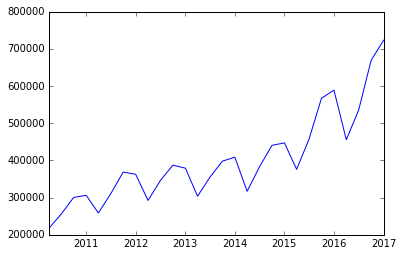

In [333]:
plt.plot(
    df_gdp['date'],
    df_gdp['value']
)
plt.show()

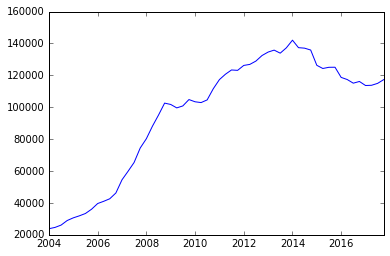

In [334]:
plt.plot(df_grossextdebt['date'],df_grossextdebt['value'])
plt.show()

In [335]:
dates = pd.date_range(datetime.date(1998,1,1), datetime.date.today())

In [336]:
df_total = exchange_rate.copy()

In [337]:
df_total['date'] = pd.to_datetime(df_total['date'])
df_total = df_total.set_index('date')

In [372]:
gdp_2017 = pd.read_csv('data/UkraineGDP.csv')

In [373]:
gdp_2017['freq'] = 'Q'
gdp_2017['date'] = pd.to_datetime(gdp_2017['date'])
gdp_2017 = gdp_2017.set_index('date')
df_gdp = df_gdp.set_index('date')

In [374]:
delta = gdp_2017['value'][datetime.datetime(2017,4,1)] - df_gdp['value'][datetime.datetime(2016,4,1)]

In [375]:
df_gdp = df_gdp.append(gdp_2017[1:])
df_gdp.loc[datetime.datetime(2010,1,1)] = ['Q', df_gdp['value'][datetime.datetime(2010,4,1)] * (1-0.042)]
df_gdp.loc[datetime.datetime(2018,1,1)] = ['Q', gdp_2017['value'][datetime.datetime(2017,1,1)] + delta * 1.034]
df_gdp.loc[datetime.datetime(2018,4,1)] = ['Q', gdp_2017['value'][datetime.datetime(2017,4,1)] + delta * 1.034]
df_gdp = df_gdp.sort_index()

In [376]:
df_gdp = df_gdp.asfreq('D')

In [377]:
df_gdp = df_gdp.apply(pd.Series.interpolate)

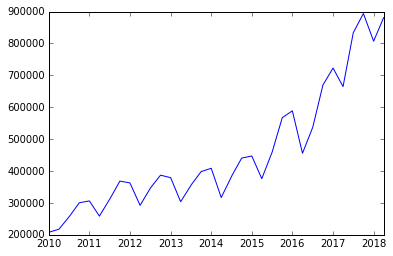

In [378]:
plt.plot(df_gdp['value'])
plt.show()

In [379]:
df_total['gdp'] = df_gdp['value']

In [446]:
df_total = df_total.loc[datetime.datetime(2010,1,1):datetime.datetime.now()]

In [395]:
df_total['gdp_in_usd'] = df_gdp['value'].divide(df_total['exchange rate'])

/home/yurii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


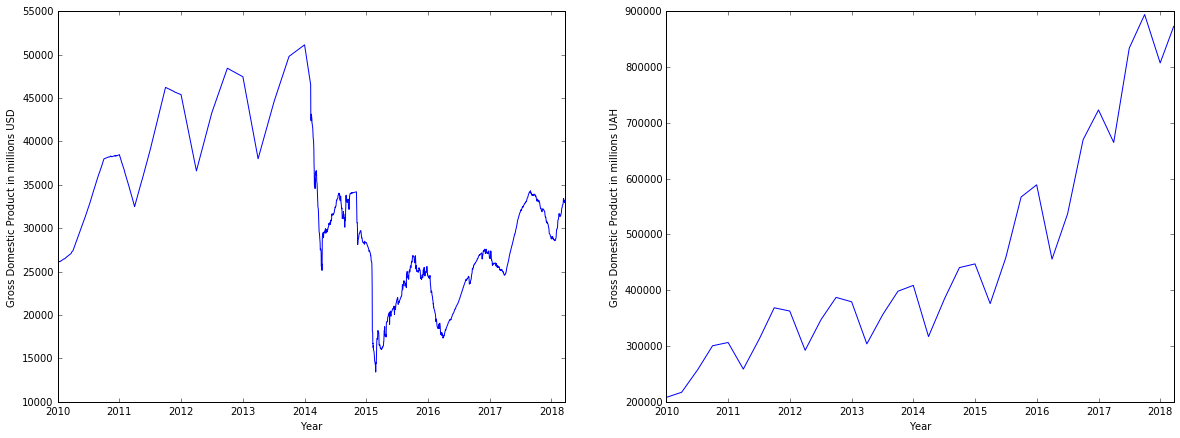

In [444]:
plt.figure(figsize=[20,7])
plt.subplot(1,2,1)
plt.plot(df_total['gdp_in_usd'])
plt.xlabel('Year')
plt.ylabel("Gross Domestic Product in millions USD")
plt.subplot(1,2,2)
plt.xlabel('Year')
plt.ylabel("Gross Domestic Product in millions UAH")
plt.plot(df_total['gdp'])
plt.show()

In [168]:
df_total.isnull().sum()

exchange rate       0
gdp              4645
dtype: int64